# Получение и предобработка данных

In [212]:
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import numpy as np
import lightgbm as lgb
pd.options.plotting.backend = "plotly"

In [213]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.where(y_true == 0, 1, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [214]:
def download_dg_data(start_date='2012-01-01', end_date='2024-01-01'):
    tickers = ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS',
           'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD',
           'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']
    
    index = yf.download("AAPL",start_date, end_date, progress = False)["Adj Close"].index
    full_data = pd.DataFrame(index=index)
    
    for i in tqdm(range(len(tickers))):
        try:
            ticker_data = yf.download(tickers[i], start_date, end_date, progress=False)["Adj Close"].rename(tickers[i])
            full_data = full_data.join(ticker_data, how='outer')
            
        except Exception as e:
            pass
    
    return full_data

In [215]:
data = download_dg_data()
data.to_csv('data2.csv', index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.07it/s]


In [216]:
data = pd.read_csv('data2.csv')

In [217]:
data = data.dropna(axis=1)

In [218]:
from ipywidgets import IntProgress
from IPython.display import display
import pandas as pd

def generate_lagged_features(data, target_cols, lags, windows, metrics):
    
    result_data = data.copy()
    
    total_iterations = len(target_cols) * len(windows) * len(lags)
    progress = IntProgress(min=0, max=total_iterations, description="Processing")
    display(progress)
    
    new_columns = {}
    
    for target_col in target_cols:
        for window in windows:
            for lag in lags:
                for metric in metrics:  

                    column_name = f"{target_col}_window{window}_lag{lag}_{metric}"
                    
                    if metric == "mean":
                        new_columns[column_name] = data[target_col].shift(lag).rolling(window).mean()
                    elif metric == "var":
                        new_columns[column_name] = data[target_col].shift(lag).rolling(window).var()
                    elif metric == "median":
                        new_columns[column_name] = data[target_col].shift(lag).rolling(window).quantile(0.5)
                    elif metric == "q1":
                        new_columns[column_name] = data[target_col].shift(lag).rolling(window).quantile(0.25)
                    elif metric == "q3":
                        new_columns[column_name] = data[target_col].shift(lag).rolling(window).quantile(0.75)
                    elif metric == "percentile_90":
                        new_columns[column_name] = data[target_col].shift(lag).rolling(window).quantile(0.9)
                    elif metric == "percentile_80":
                        new_columns[column_name] = data[target_col].shift(lag).rolling(window).quantile(0.8)
                    elif metric == "percentile_20":
                        new_columns[column_name] = data[target_col].shift(lag).rolling(window).quantile(0.2)
                    elif metric == "percentile_10":
                        new_columns[column_name] = data[target_col].shift(lag).rolling(window).quantile(0.1)

                progress.value += 1
    
    # Convert the dictionary of new columns to a DataFrame
    new_columns_df = pd.DataFrame(new_columns)
    
    # Concatenate the new DataFrame with the original DataFrame
    result_data = pd.concat([result_data, new_columns_df], axis=1)
    
    progress.close()
    
    return result_data

In [219]:
tickers = data.columns[1:]

full_data = data["Date"].copy()
full_data = pd.DataFrame(full_data)



for ticker in tickers:
    
    proxy = data["Date"].copy()
    proxy = pd.DataFrame(proxy)
    proxy["ticker"] = data[ticker].values
    
    proxy_result_data = generate_lagged_features(proxy, target_cols=["ticker"],
                                                lags=[30,45,60,75,90,180,365],
                                                windows=[1,2,3,4,5,10,20,30,60,90,180,365],
                                               metrics=['mean', 'var', "percentile_90", "percentile_10"])
    if ticker == "AAPL":
        full_data = proxy_result_data.copy()

    else:
        full_data = pd.concat([full_data, proxy_result_data])

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

IntProgress(value=0, description='Processing', max=84)

In [220]:
#Добавляем дни недели
full_data['Date'] = pd.to_datetime(full_data['Date'])
full_data.loc[:, 'day_of_week'] = full_data['Date'].dt.day_name()
full_data = pd.get_dummies(full_data,columns=["day_of_week"],drop_first=True)

In [221]:
#Удаляем полностью пустые столбцы (так как окно 1, не может быть дисперсии и инф. персентиля)
columns_to_drop = ['ticker_window1_lag30_var', 'ticker_window1_lag45_var', 'ticker_window1_lag60_var', 'ticker_window1_lag75_var', 'ticker_window1_lag90_var', 'ticker_window1_lag180_var', 'ticker_window1_lag365_var', 'ticker_window1_lag30_percentile_90', 'ticker_window1_lag45_percentile_90', 'ticker_window1_lag60_percentile_90', 'ticker_window1_lag75_percentile_90', 'ticker_window1_lag90_percentile_90', 'ticker_window1_lag180_percentile_90', 'ticker_window1_lag365_percentile_90', 'ticker_window1_lag30_percentile_10', 'ticker_window1_lag45_percentile_10', 'ticker_window1_lag60_percentile_10', 'ticker_window1_lag75_percentile_10', 'ticker_window1_lag90_percentile_10', 'ticker_window1_lag180_percentile_10', 'ticker_window1_lag365_percentile_10'] 
full_data = full_data.drop(columns=columns_to_drop)

In [222]:
horizon = 30
#Если ставим больше 30, то нужно менять сгенерированные значения, lag должен быть >= horizon

In [223]:
all_dates = full_data["Date"].copy()
all_dates = pd.DataFrame(all_dates)

dates = full_data["Date"].unique()[-horizon:]
mask = full_data['Date'].isin(dates)

old_dates = all_dates.loc[~mask]
new_dates = all_dates.loc[mask]

X_train = full_data.loc[~mask].drop(columns=["ticker","Date"])
X_test = full_data.loc[mask].drop(columns=["ticker","Date"])
y_train = full_data.loc[~mask].ticker.values
y_test = full_data.loc[mask].ticker.values

In [224]:
X_train = X_train.fillna(-10)
X_test = X_test.fillna(-10)

In [225]:
#Бокс-кокс
from scipy.stats import boxcox
from scipy.special import inv_boxcox
y_train_box, lambda_value = boxcox(y_train)

In [226]:
with open('lambda_value.pkl', 'wb') as file:
    pickle.dump(lambda_value, file)

# Обучение моделей и получение предсказаний

In [127]:
import time
import pickle
# Инициализация моделей
GB_model = lgb.LGBMRegressor(n_estimators=1000, max_depth=-1, random_state=42, n_jobs=10, verbose=-1)
RF_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=10, verbose=0)

# Измерение времени обучения GB_model
start_time = time.time()
GB_model.fit(X_train, y_train_box)
training_time_gb = time.time() - start_time

with open('GB_model.pkl', 'wb') as file:
    pickle.dump(GB_model, file)
    
# Измерение времени предсказания GB_model
start_time = time.time()
y_pred_gb = GB_model.predict(X_test)
y_pred_gb = inv_boxcox(y_pred_gb, lambda_value)
prediction_time_gb = time.time() - start_time

# Оценка MAPE GB_model
mape_gb = mean_absolute_percentage_error(y_test, y_pred_gb)

# Измерение времени обучения RF_model
start_time = time.time()
RF_model.fit(X_train, y_train_box)
training_time_rf = time.time() - start_time

with open('RF_model.pkl', 'wb') as file:
    pickle.dump(RF_model, file)

# Измерение времени предсказания RF_model
start_time = time.time()
y_pred_rf = RF_model.predict(X_test)
y_pred_rf = inv_boxcox(y_pred_rf, lambda_value)
prediction_time_rf = time.time() - start_time

# Оценка MAPE RF_model
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)

In [134]:
# Создание смешанной модели
alpha = 0.5
y_pred_combined = alpha * y_pred_gb + (1-alpha) * y_pred_rf

# Измерение времени обучения и предсказания Combined_model
start_time = time.time()
# Предположим, что обучение Combined_model включает в себя обучение обеих моделей
training_time_combined = training_time_gb + training_time_rf
# Предположим, что предсказание Combined_model включает в себя предсказание обеих моделей
prediction_time_combined = prediction_time_gb + prediction_time_rf

# Оценка MAPE Combined_model
mape_combined = mean_absolute_percentage_error(y_test, y_pred_combined)

# Создание DataFrame
data = {
    'Модель': ['GB_model', 'RF_model', 'Combined_model'],
    'Время обучения (сек)': [training_time_gb, training_time_rf, training_time_combined],
    'Время предсказания (сек)': [prediction_time_gb, prediction_time_rf, prediction_time_combined],
    'Оценка MAPE': [mape_gb, mape_rf, mape_combined]
}

df = pd.DataFrame(data)

# Вывод DataFrame
print(df)

           Модель  Время обучения (сек)  Время предсказания (сек)  Оценка MAPE
0        GB_model             15.978247                  0.010521     8.272919
1        RF_model            384.784494                  0.019000     7.805648
2  Combined_model            400.762741                  0.029521     7.992021


# Лучшая модель

In [139]:
with open('RF_model.pkl', 'rb') as file:
    RF_model = pickle.load(file)

y_pred = RF_model.predict(X_test)
y_pred = inv_boxcox(y_pred, lambda_value)
mean_absolute_percentage_error(y_test, y_pred)

7.805647643541833

In [144]:
test_dates = new_dates.copy()
test_dates.loc[:, "predictions"] = y_test
new_dates.loc[:, "predictions"] = y_pred
old_dates.loc[:, "predictions"] = y_train

sample_test = test_dates.loc[~test_dates['Date'].duplicated(keep='first')]
sample_prediction = new_dates.loc[~new_dates['Date'].duplicated(keep='first')]
sample_train = old_dates.loc[~old_dates['Date'].duplicated(keep='first')]

C:\Users\PC\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



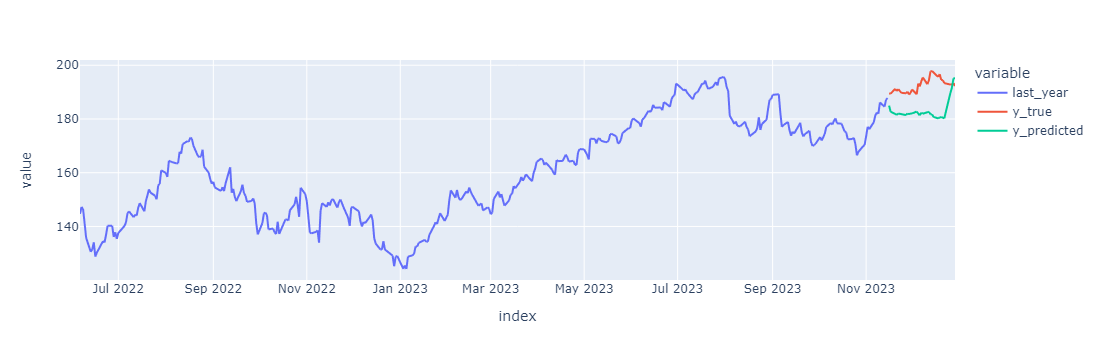

In [146]:
# Создаем датафрейм
df_to_plot = pd.DataFrame(index=all_dates[~all_dates['Date'].duplicated(keep='first')]["Date"].values[-horizon-365:])
df_to_plot['last_year'] = np.concatenate([sample_train["predictions"][-365:], np.full(horizon, np.nan)])
df_to_plot['y_true'] = np.concatenate([np.full(365, np.nan), sample_test["predictions"]])
df_to_plot['y_predicted'] = np.concatenate([np.full(365, np.nan), sample_prediction["predictions"]])
df_to_plot.plot()

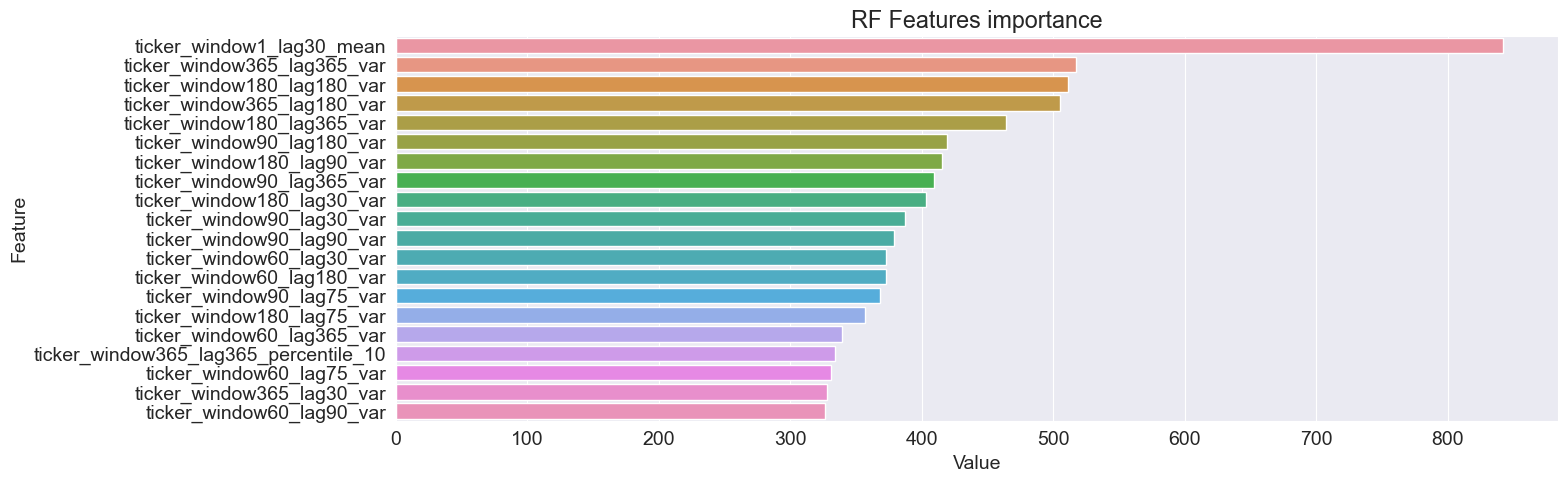

In [161]:
def plot_feature_importance(model, X , num = 20):
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.set_style("darkgrid")
    sns.mpl.rc("figure", figsize=(15, int(num/4)))
    sns.mpl.rc("font", size=14)

    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                      ascending=False)[0:num])
    plt.title('RF Features importance')
    plt.show()

plot_feature_importance(GB_model, X_train, num = 20)

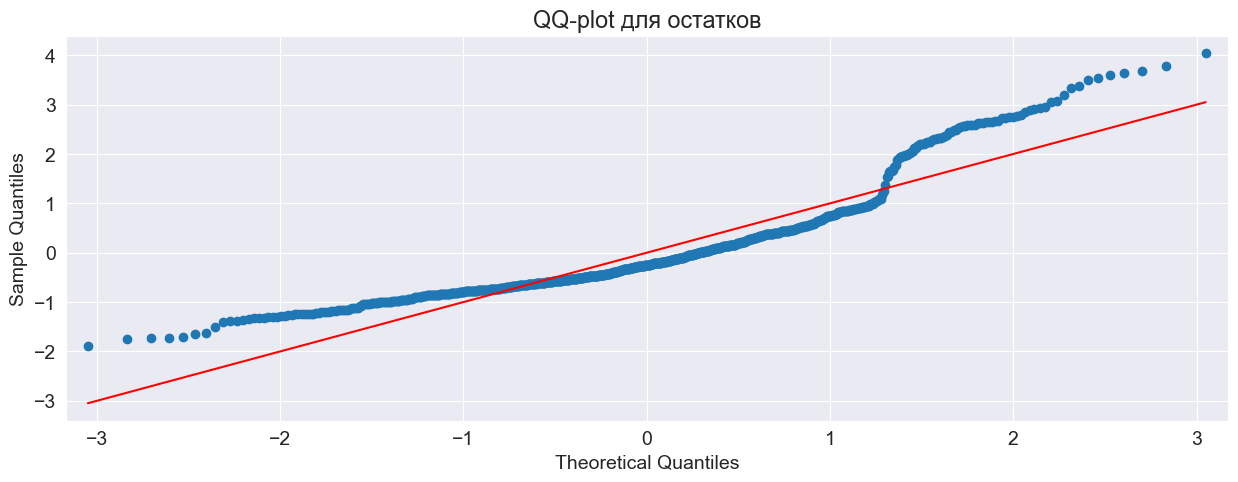

In [162]:
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
import matplotlib.pyplot as plt
residuals = y_test - y_pred
qqplot(residuals, line='s', fit=True)
plt.title('QQ-plot для остатков')
plt.show()

# Итоговый pipeline (немного условный)

In [257]:
# Main pipeline
def main(ticker):

    # Просто для теста пусть сегодня - это 30 торговых дней до 1 января 2024 года. Чтобы не лезть в будущее
    ticker = ticker
    start_date='2012-01-01'
    end_date='2024-01-01'
    test_data = pd.DataFrame(yf.download(ticker, start_date, end_date, progress=False)["Adj Close"]).reset_index(drop=False)
    test_data= test_data.rename(columns={"Adj Close": "ticker"})
    
    #Уберем последние 30 значения. Их мы будем предсказывать. На них же проверим результат
    y_true = test_data[-30:]["ticker"].copy().values
    test_data.loc[test_data.index[-30:], 'ticker'] = np.nan

    full_data = generate_lagged_features(test_data, target_cols=["ticker"],
                                            lags=[30,45,60,75,90,180,365],
                                            windows=[1,2,3,4,5,10,20,30,60,90,180,365],
                                           metrics=['mean', 'var', "percentile_90", "percentile_10"])

    #Добавляем дни недели
    full_data['Date'] = pd.to_datetime(full_data['Date'])
    full_data.loc[:, 'day_of_week'] = full_data['Date'].dt.day_name()
    full_data = pd.get_dummies(full_data,columns=["day_of_week"],drop_first=True)
    #Удаляем полностью пустые столбцы (так как окно 1, не может быть дисперсии и инф. персентиля)
    columns_to_drop = ['ticker_window1_lag30_var', 'ticker_window1_lag45_var', 'ticker_window1_lag60_var', 
                       'ticker_window1_lag75_var', 'ticker_window1_lag90_var', 'ticker_window1_lag180_var', 
                       'ticker_window1_lag365_var', 'ticker_window1_lag30_percentile_90', 'ticker_window1_lag45_percentile_90', 
                       'ticker_window1_lag60_percentile_90', 'ticker_window1_lag75_percentile_90', 'ticker_window1_lag90_percentile_90', 
                       'ticker_window1_lag180_percentile_90', 'ticker_window1_lag365_percentile_90', 'ticker_window1_lag30_percentile_10', 
                       'ticker_window1_lag45_percentile_10', 'ticker_window1_lag60_percentile_10', 'ticker_window1_lag75_percentile_10', 
                       'ticker_window1_lag90_percentile_10', 'ticker_window1_lag180_percentile_10', 'ticker_window1_lag365_percentile_10'] 
    full_data = full_data.drop(columns=columns_to_drop)

    X = full_data[-30:].drop(columns=["ticker","Date"])

    with open('RF_model.pkl', 'rb') as file:
        loaded_RF_model = pickle.load(file)

    with open('lambda_value.pkl', 'rb') as file:
        loaded_lambda_value = pickle.load(file)
    
    # Прогноз с использованием pipeline
    forecast = loaded_RF_model.predict(X)
    y_pred = inv_boxcox(forecast, loaded_lambda_value)
    MAPE = mean_absolute_percentage_error(y_true, y_pred)

    return y_true, y_pred, MAPE

In [258]:
y_true, y_pred, MAPE = main("AAPL")
print("Предсказания: ", y_pred)
print("Реальные значения: ", y_true)
print("Оценка MAPE: ", MAPE)

IntProgress(value=0, description='Processing', max=84)

Предсказания:  [184.97003887 182.67861454 181.89571421 181.50878217 182.02784817
 181.79785421 181.45303486 182.02469171 181.79013542 182.02171853
 182.05608222 182.75733572 182.03130889 181.35950804 182.35234912
 181.9687344  182.51192395 182.65169262 181.72482461 181.71057304
 180.76393631 180.22026671 180.55641253 180.69352754 180.51954675
 180.22190004 189.70493599 191.70749246 195.08301977 195.2206323 ]
Реальные значения:  [189.46824646 189.44825745 191.20600891 190.39704895 191.06619263
 189.72790527 189.54812622 190.15734863 189.12866211 189.70791626
 190.99629211 189.18858337 193.17350769 192.07492065 194.02243042
 195.46058655 192.93380737 194.46186829 197.7077179  197.85752869
 197.31822205 195.64035034 196.68902588 194.58171082 194.43188477
 193.35328674 192.8039856  192.90383911 193.33329773 192.28463745]
Оценка MAPE:  5.038539049980053
